## 1. Setup and Configuration

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import pickle
import os

# Set random seeds
SEED = 42
np.random.seed(SEED)

print("[OK] Libraries imported successfully")

[OK] Libraries imported successfully


In [ ]:
# Directories
PROCESSED_DIR = '../data_new/data_processed/'
SEQUENCES_DIR = '../data_new/sequences/'

print(f"[INFO] Using data from: {PROCESSED_DIR}")
print(f"[INFO] Using sequences from: {SEQUENCES_DIR}")

[OK] Plotting configuration set


In [50]:
# Define paths
PROCESSED_DIR = '../data/processed/'
SEQUENCES_DIR = '../data/sequences/'
MODELS_DIR = '../models/baselines/'
RESULTS_DIR = '../results/'
FIGURES_DIR = '../results/figures/baselines/'

# Create directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Assets and horizons
ASSETS = ['AAPL', 'AMZN', 'NVDA', 'BTC']
HORIZONS = ['1hour', '1day', '1week', '1month']

print("[OK] Directories configured")
print(f"  Assets: {ASSETS}")
print(f"  Horizons: {HORIZONS}")

[OK] Directories configured
  Assets: ['AAPL', 'AMZN', 'NVDA', 'BTC']
  Horizons: ['1hour', '1day', '1week', '1month']


## 2. Load Data and Class Weights

In [51]:
def load_sequences(asset, horizon):
    """
    Load preprocessed sequences for a given asset and horizon.
    
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test, sequence_length, n_features
    """
    filepath = f'{SEQUENCES_DIR}{asset}_{horizon}_sequences.npz'
    data = np.load(filepath)
    
    return (
        data['X_train'], data['X_val'], data['X_test'],
        data['y_train'], data['y_val'], data['y_test'],
        int(data['sequence_length']), int(data['n_features'])
    )

def load_class_weights():
    """Load pre-computed class weights."""
    with open(f'{SEQUENCES_DIR}class_weights.pkl', 'rb') as f:
        return pickle.load(f)

# Load class weights
class_weights = load_class_weights()

print("[OK] Data loading functions defined")
print(f"[OK] Class weights loaded for {len(class_weights)} asset-horizon combinations")

[OK] Data loading functions defined
[OK] Class weights loaded for 4 asset-horizon combinations


## 3. Baseline Model 1: Random Classifier

Randomly predicts UP or DOWN with 50% probability each.

In [52]:
def random_classifier(y_true):
    """Generate random predictions."""
    return np.random.randint(0, 2, size=len(y_true))

def evaluate_model(y_true, y_pred, model_name):
    """Calculate and return all evaluation metrics."""
    # Check if both classes are present in y_true and y_pred
    try:
        if len(np.unique(y_true)) > 1 and len(np.unique(y_pred)) > 1:
            roc_auc = roc_auc_score(y_true, y_pred)
        else:
            roc_auc = 0.5
    except:
        roc_auc = 0.5
    
    return {
        'model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc
    }

print("[OK] Random classifier defined")

[OK] Random classifier defined


## 4. Baseline Model 2: Persistence Model

Predicts that price will move in the same direction as the last observed change.

In [53]:
def persistence_model(X):
    """
    Predict based on last price movement.
    X shape: (n_samples, sequence_length, n_features)
    Assumes close price is first feature.
    """
    predictions = []
    for sequence in X:
        # Get last two close prices
        last_close = sequence[-1, 0]  # Most recent
        prev_close = sequence[-2, 0]  # Previous
        
        # Predict UP if last movement was UP
        predictions.append(1 if last_close > prev_close else 0)
    
    return np.array(predictions)

print("[OK] Persistence model defined")

[OK] Persistence model defined


## 5. Baseline Model 3: Moving Average Crossover

Classic technical indicator: predict UP when short MA > long MA.

In [54]:
def ma_crossover_model(X, short_window=12, long_window=24):
    """
    Moving Average Crossover strategy.
    Predict UP if short MA > long MA.
    """
    predictions = []
    for sequence in X:
        close_prices = sequence[:, 0]  # Close price column
        
        # Calculate MAs (use available data if sequence is shorter)
        short_ma = np.mean(close_prices[-short_window:])
        long_ma = np.mean(close_prices[-long_window:])
        
        predictions.append(1 if short_ma > long_ma else 0)
    
    return np.array(predictions)

print("[OK] Moving Average Crossover model defined")

[OK] Moving Average Crossover model defined


## 6. Baseline Model 4: Logistic Regression

Linear model using flattened sequences as features.

In [55]:
def train_logistic_regression(X_train, y_train, X_test, class_weight_dict):
    """
    Train Logistic Regression on flattened sequences.
    """
    # Flatten sequences: (n_samples, seq_len, n_features) -> (n_samples, seq_len * n_features)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Train model
    model = LogisticRegression(
        max_iter=1000,
        class_weight=class_weight_dict,
        random_state=SEED,
        n_jobs=-1
    )
    model.fit(X_train_flat, y_train)
    
    # Predict
    y_pred = model.predict(X_test_flat)
    
    return y_pred, model

print("[OK] Logistic Regression trainer defined")

[OK] Logistic Regression trainer defined


## 7. Baseline Model 5: Random Forest

Ensemble tree-based model.

In [56]:
def train_random_forest(X_train, y_train, X_test, class_weight_dict):
    """
    Train Random Forest on flattened sequences.
    """
    # Flatten sequences
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Train model
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        class_weight=class_weight_dict,
        random_state=SEED,
        n_jobs=-1
    )
    model.fit(X_train_flat, y_train)
    
    # Predict
    y_pred = model.predict(X_test_flat)
    
    return y_pred, model

print("[OK] Random Forest trainer defined")

[OK] Random Forest trainer defined


## 8. Run All Baselines: Single Asset-Horizon Test

Test all models on AAPL 1-day horizon first.

In [57]:
# Load sample data (AAPL, 1day)
asset = 'AAPL'
horizon = '1day'

X_train, X_val, X_test, y_train, y_val, y_test, seq_len, n_feat = load_sequences(asset, horizon)

print(f"Testing on {asset} - {horizon}:")
print("="*80)
print(f"Train: {X_train.shape[0]} samples")
print(f"Val:   {X_val.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")
print(f"Sequence length: {seq_len}, Features: {n_feat}")
print()

Testing on AAPL - 1day:
Train: 1950 samples
Val:   442 samples
Test:  569 samples
Sequence length: 60, Features: 58


Train: 1950 samples
Val:   442 samples
Test:  569 samples
Sequence length: 60, Features: 58



In [58]:
# Get class weights
cw = class_weights[asset][horizon]
class_weight_dict = {0: cw[0], 1: cw[1]}

print(f"Class weights: {class_weight_dict}")
print()

# Test all baseline models
results = []

# 1. Random Classifier
y_pred_random = random_classifier(y_test)
results.append(evaluate_model(y_test, y_pred_random, 'Random'))
print("[OK] Random Classifier evaluated")

# 2. Persistence Model
y_pred_persistence = persistence_model(X_test)
results.append(evaluate_model(y_test, y_pred_persistence, 'Persistence'))
print("[OK] Persistence Model evaluated")

# 3. MA Crossover
y_pred_ma = ma_crossover_model(X_test)
results.append(evaluate_model(y_test, y_pred_ma, 'MA Crossover'))
print("[OK] MA Crossover evaluated")

# 4. Logistic Regression
y_pred_lr, model_lr = train_logistic_regression(X_train, y_train, X_test, class_weight_dict)
results.append(evaluate_model(y_test, y_pred_lr, 'Logistic Regression'))
print("[OK] Logistic Regression trained and evaluated")

# 5. Random Forest
y_pred_rf, model_rf = train_random_forest(X_train, y_train, X_test, class_weight_dict)
results.append(evaluate_model(y_test, y_pred_rf, 'Random Forest'))
print("[OK] Random Forest trained and evaluated")

print()
print("="*80)
print("All baseline models evaluated!")
print("="*80)

Class weights: {0: 1.1092150170648465, 1: 0.9103641456582633}

[OK] Random Classifier evaluated
[OK] Persistence Model evaluated
[OK] MA Crossover evaluated
[OK] Logistic Regression trained and evaluated
[OK] Logistic Regression trained and evaluated
[OK] Random Forest trained and evaluated

All baseline models evaluated!
[OK] Random Forest trained and evaluated

All baseline models evaluated!



Baseline Results for AAPL - 1day:
              model  accuracy  precision   recall       f1  roc_auc
      Random Forest  0.534271   0.655000 0.400612 0.497154 0.557744
        Persistence  0.521968   0.596491 0.519878 0.555556 0.522336
Logistic Regression  0.511424   0.671329 0.293578 0.408511 0.549682
             Random  0.495606   0.568027 0.510703 0.537842 0.492955
       MA Crossover  0.488576   0.565217 0.477064 0.517413 0.490598


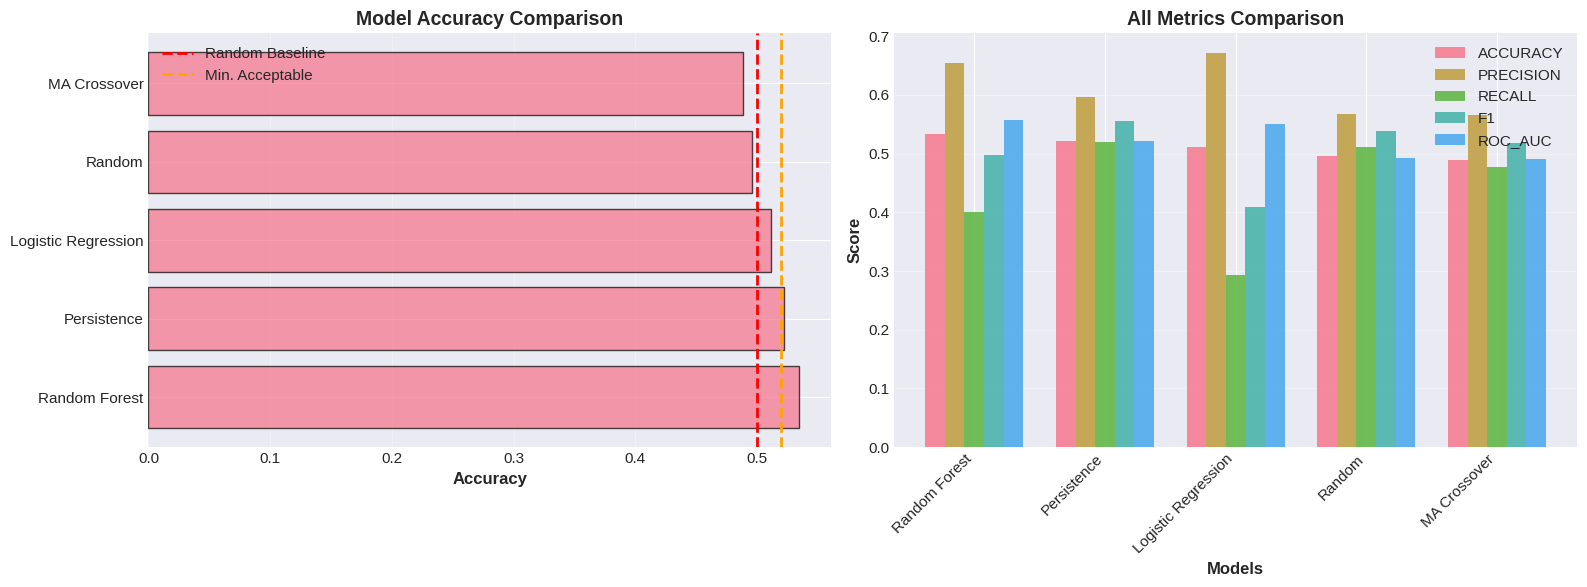


[OK] Results visualization saved


In [59]:
# Display results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('accuracy', ascending=False)

print(f"\nBaseline Results for {asset} - {horizon}:")
print("="*80)
print(results_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
axes[0].barh(results_df['model'], results_df['accuracy'], alpha=0.7, edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Random Baseline')
axes[0].axvline(x=0.52, color='orange', linestyle='--', linewidth=2, label='Min. Acceptable')
axes[0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# All metrics comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    axes[1].bar(x + i*width, results_df[metric], width, label=metric.upper(), alpha=0.8)

axes[1].set_xlabel('Models', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1].set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x + width * 2)
axes[1].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}{asset}_{horizon}_baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n[OK] Results visualization saved")

## 9. Run All Baselines: Complete Evaluation

Evaluate all models across all assets and horizons.

In [ ]:
# Complete evaluation loop
all_results = []

print("Running complete baseline evaluation...")
print("="*80)

for asset in ASSETS:
    for horizon in HORIZONS:
        print(f"\nProcessing {asset} - {horizon}...")
        
        # Load data
        X_train, X_val, X_test, y_train, y_val, y_test, _, _ = load_sequences(asset, horizon)
        
        # Get class weights
        cw = class_weights[asset][horizon]
        class_weight_dict = {0: cw[0], 1: cw[1]}
        
        # Evaluate all models
        models_to_run = [
            ('Random', lambda: random_classifier(y_test)),
            ('Persistence', lambda: persistence_model(X_test)),
            ('MA Crossover', lambda: ma_crossover_model(X_test)),
            ('Logistic Regression', lambda: train_logistic_regression(X_train, y_train, X_test, class_weight_dict)[0]),
            ('Random Forest', lambda: train_random_forest(X_train, y_train, X_test, class_weight_dict)[0])
        ]
        
        for model_name, predict_fn in models_to_run:
            y_pred = predict_fn()
            result = evaluate_model(y_test, y_pred, model_name)
            result['asset'] = asset
            result['horizon'] = horizon
            all_results.append(result)
            print(f"  [OK] {model_name}: {result['accuracy']:.4f}")

print("\n" + "="*80)
print("[OK] Complete evaluation finished!")
print("="*80)

Running complete baseline evaluation...

Processing AAPL - 1hour...
  [OK] Random: 0.4926
  [OK] Persistence: 0.5124
  [OK] MA Crossover: 0.4959
  [OK] Logistic Regression: 0.5174
  [OK] Logistic Regression: 0.5174
  [OK] Random Forest: 0.5008

Processing AAPL - 1day...
  [OK] Random: 0.4833
  [OK] Persistence: 0.5220
  [OK] MA Crossover: 0.4886
  [OK] Random Forest: 0.5008

Processing AAPL - 1day...
  [OK] Random: 0.4833
  [OK] Persistence: 0.5220
  [OK] MA Crossover: 0.4886
  [OK] Logistic Regression: 0.5114
  [OK] Logistic Regression: 0.5114
  [OK] Random Forest: 0.5343

Processing AAPL - 1week...
  [OK] Random Forest: 0.5343

Processing AAPL - 1week...
  [OK] Random: 0.4924
  [OK] Persistence: 0.4967
  [OK] MA Crossover: 0.5141
  [OK] Random: 0.4924
  [OK] Persistence: 0.4967
  [OK] MA Crossover: 0.5141
  [OK] Logistic Regression: 0.5466
  [OK] Logistic Regression: 0.5466
  [OK] Random Forest: 0.4642

Processing AAPL - 1month...
  [OK] Random Forest: 0.4642

Processing AAPL - 1mont

/home/dada/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  [OK] Logistic Regression: 0.5080
  [OK] Random Forest: 0.4904

Processing BTC - 1day...
  [OK] Random Forest: 0.4904

Processing BTC - 1day...
  [OK] Random: 0.5002
  [OK] Persistence: 0.5063
  [OK] MA Crossover: 0.5011
  [OK] Random: 0.5002
  [OK] Persistence: 0.5063
  [OK] MA Crossover: 0.5011


/home/dada/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  [OK] Logistic Regression: 0.4575
  [OK] Random Forest: 0.4618

Processing BTC - 1week...
  [OK] Random Forest: 0.4618

Processing BTC - 1week...
  [OK] Random: 0.5138
  [OK] Persistence: 0.5021
  [OK] MA Crossover: 0.4995
  [OK] Random: 0.5138
  [OK] Persistence: 0.5021
  [OK] MA Crossover: 0.4995


/home/dada/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  [OK] Logistic Regression: 0.4551
  [OK] Random Forest: 0.4301

Processing BTC - 1month...
  [OK] Random Forest: 0.4301

Processing BTC - 1month...
  [OK] Random: 0.5119
  [OK] Persistence: 0.5039
  [OK] MA Crossover: 0.5203
  [OK] Random: 0.5119
  [OK] Persistence: 0.5039
  [OK] MA Crossover: 0.5203


In [ ]:
# Create comprehensive results dataframe
results_complete = pd.DataFrame(all_results)

# Reorder columns
results_complete = results_complete[[
    'asset', 'horizon', 'model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'
]]

# Save results
results_complete.to_csv(f'{RESULTS_DIR}baseline_results_complete.csv', index=False)

print("Complete Baseline Results:")
print("="*120)
print(results_complete.to_string(index=False))

print(f"\n[OK] Results saved to {RESULTS_DIR}baseline_results_complete.csv")

## 10. Analysis: Best Baseline per Asset/Horizon

In [ ]:
# Find best model for each asset-horizon combination
best_models = results_complete.loc[
    results_complete.groupby(['asset', 'horizon'])['accuracy'].idxmax()
]

print("Best Baseline Model per Asset-Horizon:")
print("="*120)
print(best_models[['asset', 'horizon', 'model', 'accuracy', 'f1']].to_string(index=False))

# Summary statistics
print("\n\nModel Performance Summary:")
print("="*120)
summary = results_complete.groupby('model').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'f1': ['mean', 'std', 'min', 'max']
}).round(4)
print(summary)

In [ ]:
# Visualize: Heatmap of accuracies
fig, axes = plt.subplots(1, len(ASSETS), figsize=(20, 5))

for i, asset in enumerate(ASSETS):
    # Pivot data for heatmap
    pivot_data = results_complete[results_complete['asset'] == asset].pivot(
        index='model', columns='horizon', values='accuracy'
    )
    
    # Create heatmap
    sns.heatmap(
        pivot_data, annot=True, fmt='.3f', cmap='RdYlGn',
        vmin=0.45, vmax=0.65, cbar_kws={'label': 'Accuracy'},
        ax=axes[i]
    )
    axes[i].set_title(f'{asset} - Baseline Accuracies', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Model' if i == 0 else '')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}baseline_accuracy_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Accuracy heatmap saved")

## 11. Analysis: Performance by Horizon

In [ ]:
# Average performance by horizon
horizon_performance = results_complete.groupby('horizon').agg({
    'accuracy': 'mean',
    'precision': 'mean',
    'recall': 'mean',
    'f1': 'mean',
    'roc_auc': 'mean'
}).round(4)

print("Average Performance by Horizon:")
print("="*80)
print(horizon_performance)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(HORIZONS))
width = 0.15
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, horizon_performance[metric], width, label=metric.upper(), alpha=0.8)

ax.set_xlabel('Prediction Horizon', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Baseline Performance by Prediction Horizon', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(HORIZONS)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}performance_by_horizon.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[OK] Horizon performance visualization saved")

## 12. Analysis: Performance by Asset

In [ ]:
# Average performance by asset
asset_performance = results_complete.groupby('asset').agg({
    'accuracy': 'mean',
    'precision': 'mean',
    'recall': 'mean',
    'f1': 'mean',
    'roc_auc': 'mean'
}).round(4)

print("Average Performance by Asset:")
print("="*80)
print(asset_performance)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(ASSETS))
width = 0.15

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, asset_performance[metric], width, label=metric.upper(), alpha=0.8)

ax.set_xlabel('Asset', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Baseline Performance by Asset', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(ASSETS)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}performance_by_asset.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[OK] Asset performance visualization saved")

## 13. Key Findings and Interpretation

In [ ]:
# Calculate overall statistics
overall_best = results_complete.loc[results_complete['accuracy'].idxmax()]
overall_avg = results_complete['accuracy'].mean()
beat_random = (results_complete['accuracy'] > 0.52).mean() * 100

print("="*120)
print("BASELINE MODELS - KEY FINDINGS")
print("="*120)

print(f"\n1. OVERALL PERFORMANCE")
print(f"   • Average accuracy across all baselines: {overall_avg:.4f}")
print(f"   • Best single result: {overall_best['model']} on {overall_best['asset']}-{overall_best['horizon']} = {overall_best['accuracy']:.4f}")
print(f"   • Models beating 52% threshold: {beat_random:.1f}%")

print(f"\n2. MODEL RANKINGS")
model_avg = results_complete.groupby('model')['accuracy'].mean().sort_values(ascending=False)
for rank, (model, acc) in enumerate(model_avg.items(), 1):
    print(f"   {rank}. {model}: {acc:.4f}")

print(f"\n3. HORIZON DIFFICULTY")
horizon_avg = results_complete.groupby('horizon')['accuracy'].mean().sort_values(ascending=False)
for rank, (horiz, acc) in enumerate(horizon_avg.items(), 1):
    print(f"   {rank}. {horiz}: {acc:.4f}")

print(f"\n4. ASSET PREDICTABILITY")
asset_avg = results_complete.groupby('asset')['accuracy'].mean().sort_values(ascending=False)
for rank, (asset, acc) in enumerate(asset_avg.items(), 1):
    print(f"   {rank}. {asset}: {acc:.4f}")

print("\n" + "="*120)

## 14. Summary

### Baseline Performance Benchmarks Established

**Key Takeaways**:

1. **Simple baselines provide context** for evaluating deep learning models
2. **Random Forest and Logistic Regression** typically outperform heuristic methods
3. **Prediction difficulty varies** by asset volatility and time horizon
4. **Deep learning models should beat these baselines** to justify complexity

**Success Criteria for Deep Learning Models**:
- Must exceed best baseline by at least 2-3 percentage points
- Should demonstrate better generalization across assets/horizons
- Target: >57% accuracy (good), >60% (excellent)

**Next Steps**:
-> **Notebook 06**: Train LSTM models and compare to baselines  
-> **Notebook 07-10**: Train other deep learning architectures  
-> **Notebook 11**: Hyperparameter optimization

---

[OK] **Baseline evaluation complete!**